In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from itertools import combinations
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [86]:
#Cleaned dataset
df = pd.read_csv('Karimnagar.csv', parse_dates=['date'], index_col='date', date_parser=lambda x: pd.to_datetime(x, format='%d-%m-%Y'))
df = df.drop(['District','Constructed date','Average of Year','datevalue','Max of temp_max'], axis=1)
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.head()

,Average of cumm_rainfall,Average of temp_min,Average of temp_max,Average of humidity_min,Average of humidity_max,Average of wind_speed_min,Average of wind_speed_max,AQI
date,,,,,,,,
2018-01-01,0.0,14.72,31.88,29.28,84.64,0.0,5.50,111
2018-01-02,0.0,14.46,31.88,33.46,86.26,0.0,5.86,111
2018-01-03,0.0,14.27,31.09,33.86,86.54,0.0,4.94,111
2018-01-04,0.0,13.48,30.91,31.54,85.55,0.0,6.22,111
2018-01-05,0.0,13.01,29.75,29.34,84.24,0.0,5.78,111


In [87]:
df.corr()

,Average of cumm_rainfall,Average of temp_min,Average of temp_max,Average of humidity_min,Average of humidity_max,Average of wind_speed_min,Average of wind_speed_max,AQI
Average of cumm_rainfall,1.000000,0.093736,-0.219213,0.402653,0.246998,0.157074,0.222934,-0.115097
Average of temp_min,0.093736,1.000000,0.576229,0.195277,-0.292547,0.311300,0.550021,-0.308348
Average of temp_max,-0.219213,0.576229,1.000000,-0.624179,-0.710478,0.069846,0.287723,-0.170159
Average of humidity_min,0.402653,0.195277,-0.624179,1.000000,0.704898,0.125763,0.064508,-0.063925
Average of humidity_max,0.246998,-0.292547,-0.710478,0.704898,1.000000,-0.148934,-0.259812,0.075098
Average of wind_speed_min,0.157074,0.311300,0.069846,0.125763,-0.148934,1.000000,0.454641,-0.034905
Average of wind_speed_max,0.222934,0.550021,0.287723,0.064508,-0.259812,0.454641,1.000000,-0.239333
AQI,-0.115097,-0.308348,-0.170159,-0.063925,0.075098,-0.034905,-0.239333,1.000000


In [88]:
#Check and deal with Null values in dataset
null_counts = df.isnull().sum()
total_null = null_counts.sum()

print(null_counts)
print(total_null)

Average of cumm_rainfall       0
Average of temp_min            0
Average of temp_max            0
Average of humidity_min        0
Average of humidity_max        0
Average of wind_speed_min      0
Average of wind_speed_max    120
AQI                            0
dtype: int64
120


date
2018-01-01    5.50
2018-01-02    5.86
2018-01-03    4.94
2018-01-04    6.22
2018-01-05    5.78
              ... 
2021-12-27    6.27
2021-12-28    7.12
2021-12-29    7.73
2021-12-30    8.16
2021-12-31    7.51
Name: Average of wind_speed_max, Length: 1461, dtype: float64


<AxesSubplot:xlabel='date'>

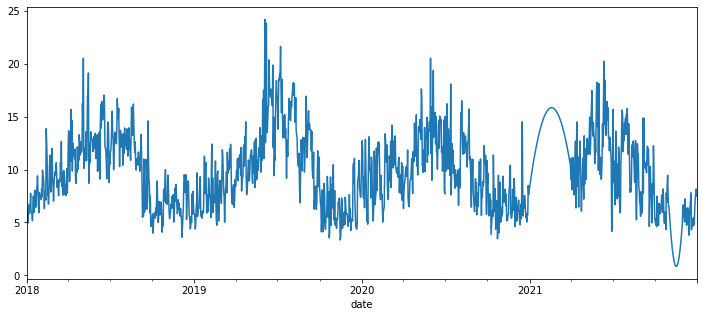

In [89]:
#Interpolate values
df['Average of wind_speed_max'].interpolate(method='spline', order=2, inplace=True)
print(df['Average of wind_speed_max'])

df['Average of wind_speed_max'].plot(figsize=(12,5))

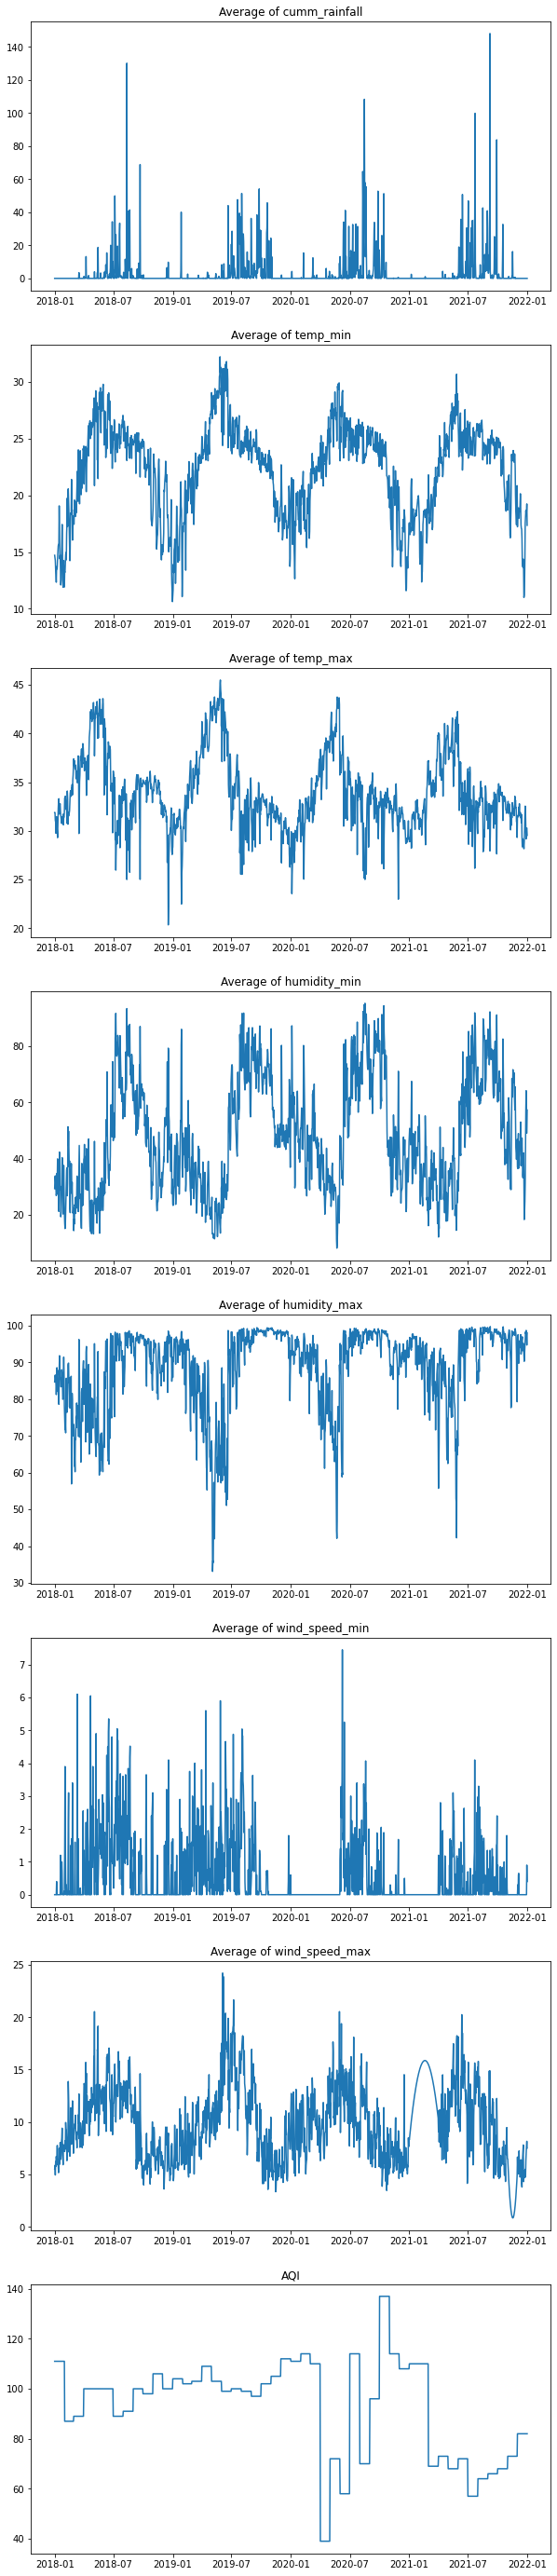

In [90]:
#Plot values
columns = df.columns
fig, axs = plt.subplots(nrows=len(columns), figsize=(10, 50))
for i, column in enumerate(columns):
    axs[i].plot(df[column])
    axs[i].set_title(column)

In [91]:
df.shape

(1461, 8)

In [92]:
#Granger Casuality test
maxlag=12
test = 'ssr_chi2test'

def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        

,Average of cumm_rainfall_x,Average of temp_min_x,Average of temp_max_x,Average of humidity_min_x,Average of humidity_max_x,Average of wind_speed_min_x,Average of wind_speed_max_x,AQI_x
Average of cumm_rainfall_y,1.0000,0.0000,0.0412,0.0000,0.0000,0.0001,0.0058,0.0010
Average of temp_min_y,0.0000,1.0000,0.0026,0.2143,0.0058,0.0794,0.0000,0.0166
Average of temp_max_y,0.0000,0.0000,1.0000,0.0466,0.0000,0.0003,0.0000,0.1183
Average of humidity_min_y,0.0000,0.0000,0.0000,1.0000,0.0000,0.2870,0.0000,0.2286
Average of humidity_max_y,0.3324,0.0000,0.0000,0.0000,1.0000,0.0003,0.0203,0.4625
Average of wind_speed_min_y,0.0000,0.0000,0.0000,0.0002,0.0018,1.0000,0.0000,0.4544
Average of wind_speed_max_y,0.0000,0.0000,0.0000,0.0203,0.0000,0.0002,1.0000,0.0443
AQI_y,0.6630,0.7349,0.2822,0.1658,0.2748,0.6985,0.5195,1.0000


In [95]:
#Split data into testing and training
nobs = 60
df_train, df_test = df[0:-nobs], df[-nobs:]
print(df_train.shape)
print(df_test.shape)

(1401, 8)
(60, 8)


In [96]:
#Adfuller test function
def adfuller_test(series, signif=0.05, name='', verbose=False):
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'   Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [97]:
#Perfrom ADF-fuller on each time series
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')


    Augmented Dickey-Fuller Test on "Average of cumm_rainfall" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1772
 No. Lags Chosen       = 21
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Average of temp_min" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7768
 No. Lags Chosen       = 12
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0617. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Average of temp_max" 
    -----------------------------------------------
 Null H

In [98]:
#Take difference on lags
df_differenced = df_train.diff().dropna()

In [99]:
#Perfrom ADF-fuller on each time series again
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "Average of cumm_rainfall" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -13.5504
 No. Lags Chosen       = 23
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Average of temp_min" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.9911
 No. Lags Chosen       = 11
 Critical value 1%     = -3.435
 Critical value 5%     = -2.864
 Critical value 10%    = -2.568
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Average of temp_max" 
    -----------------------------------------------
 Null Hypothesis: Data has uni

In [100]:
#Selecting order of VAR model
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

C:\Users\Apoorva\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


Lag Order = 1
AIC :  16.464351985284683
BIC :  16.73421112336611
FPE :  14137669.733915964
HQIC:  16.56523497891918 

Lag Order = 2
AIC :  16.057368270421737
BIC :  16.567397252896665
FPE :  9410887.87378238
HQIC:  16.24804213534718 

Lag Order = 3
AIC :  15.912789290470712
BIC :  16.663266364093758
FPE :  8144226.764156723
HQIC:  16.19336446118659 

Lag Order = 4
AIC :  15.806610196808434
BIC :  16.797814135774832
FPE :  7324098.7735696975
HQIC:  16.17719732297539 

Lag Order = 5
AIC :  15.752605593848102
BIC :  16.98481570117125
FPE :  6939505.434326775
HQIC:  16.21331554085923 

Lag Order = 6
AIC :  15.740389017077867
BIC :  17.213885125971427
FPE :  6855904.577045474
HQIC:  16.29133286663191 

Lag Order = 7
AIC :  15.75123664428627
BIC :  17.46629911955087
FPE :  6931608.236440566
HQIC:  16.392525694962757 

Lag Order = 8
AIC :  15.773406596833855
BIC :  17.730316336248414
FPE :  7088259.168166879
HQIC:  16.50515236467015 

Lag Order = 9
AIC :  15.786952016358958
BIC :  17.98599045

In [103]:
#Automated method to choose lag model
x=model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,17.69,17.72,4.824e+07,17.70
1,16.50,16.78,1.472e+07,16.61
2,16.09,16.60*,9.746e+06,16.28
3,15.94,16.70,8.393e+06,16.22
4,15.83,16.83,7.520e+06,16.20*
5,15.77,17.01,7.089e+06,16.24
6,15.76*,17.23,6.969e+06*,16.31
7,15.76,17.48,7.010e+06,16.40
8,15.78,17.74,7.133e+06,16.51
9,15.79,17.99,7.196e+06,16.61


In [102]:
model_fitted = model.fit(6)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 04, Mar, 2023
Time:                     21:33:46
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    17.2139
Nobs:                     1394.00    HQIC:                   16.2913
Log likelihood:          -26403.1    FPE:                6.85590e+06
AIC:                      15.7404    Det(Omega_mle):     5.20039e+06
--------------------------------------------------------------------
Results for equation Average of cumm_rainfall
                                  coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------------------
const                               -0.006348         0.281519           -0.023           0.982
L1.Average of cumm_rainfall         -0.712425         0.029602          -24.0

In [105]:
#Durban Watson Statistic
out = durbin_watson(model_fitted.resid)
for i, val in enumerate(out):
    print('DW statistic for variable {}: {:.2f}'.format(df.columns[i], val))

DW statistic for variable Average of cumm_rainfall: 2.02
DW statistic for variable Average of temp_min: 2.01
DW statistic for variable Average of temp_max: 2.00
DW statistic for variable Average of humidity_min: 2.01
DW statistic for variable Average of humidity_max: 2.02
DW statistic for variable Average of wind_speed_min: 2.02
DW statistic for variable Average of wind_speed_max: 2.01
DW statistic for variable AQI: 2.00


In [106]:
#Obtain lag order
lag_order = model_fitted.k_ar
print(lag_order)

6


In [107]:
#Forecasting using this model
forecast_input = df_differenced.values[-lag_order:]
forecast_input

array([[  0.        ,  -0.17      ,   0.        ,  -4.98      ,
         -1.17      ,  -0.5       ,  -0.9       ,   0.        ],
       [  0.        ,   1.05      ,  -0.38      ,   1.78      ,
         -3.78      ,   0.        ,   1.69      ,   0.        ],
       [  0.        ,   0.26      ,   0.3       ,  -0.32      ,
         -3.16      ,   1.8       ,   0.88      ,   0.        ],
       [  0.        ,   1.34      ,  -0.14      ,  10.98      ,
          2.66      ,  -1.6       ,  -1.91      ,   0.        ],
       [  0.        ,  -0.42      ,   0.67      ,   2.32      ,
          5.11      ,  -0.2       ,  -1.07      ,   0.        ],
       [  0.        ,  -2.13      ,  -0.09      , -14.44      ,
         -1.85      ,   0.        ,  -0.02648523,   5.        ]])

In [108]:
#Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,Average of cumm_rainfall_2d,Average of temp_min_2d,Average of temp_max_2d,Average of humidity_min_2d,Average of humidity_max_2d,Average of wind_speed_min_2d,Average of wind_speed_max_2d,AQI_2d
date,,,,,,,,
2021-11-02,0.869176,0.109255,0.025918,-0.811563,-1.602564,-0.057505,0.029150,-0.106982
2021-11-03,-3.078126,0.383697,-0.350728,3.401851,2.608057,0.128964,0.221661,-0.223274
2021-11-04,1.346915,0.214964,0.331266,-0.084905,-0.856699,0.172234,0.166076,0.203990
2021-11-05,0.657180,0.133395,-0.129846,0.473193,-1.040439,0.163589,0.318352,0.333067
2021-11-06,-0.279888,0.045569,-0.143283,0.503148,-0.570449,-0.156320,-0.288482,-0.469201
2021-11-07,1.060231,0.095217,0.307751,-0.408324,0.470444,-0.037608,-0.130117,-0.023680
2021-11-08,-0.648415,-0.152469,-0.086590,-0.076188,0.151916,0.002635,0.129274,0.032182
2021-11-09,-0.374107,-0.089289,-0.077471,-0.067276,0.036220,-0.056800,-0.118440,0.015468
2021-11-10,-0.357054,0.019270,0.015866,-0.071690,0.334440,0.027998,0.061838,-0.019628


In [109]:
#Invert back to get the real forecast
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [110]:
#Display results
df_results = invert_transformation(df_train, df_forecast, second_diff=True) 
print(df_results)

            Average of cumm_rainfall_2d  Average of temp_min_2d  \
date                                                              
2021-11-02                     0.869176                0.109255   
2021-11-03                    -3.078126                0.383697   
2021-11-04                     1.346915                0.214964   
2021-11-05                     0.657180                0.133395   
2021-11-06                    -0.279888                0.045569   
2021-11-07                     1.060231                0.095217   
2021-11-08                    -0.648415               -0.152469   
2021-11-09                    -0.374107               -0.089289   
2021-11-10                    -0.357054                0.019270   
2021-11-11                     0.448369                0.022275   
2021-11-12                     0.208231                0.038281   
2021-11-13                    -0.186313                0.013745   
2021-11-14                     0.084436                0.01456

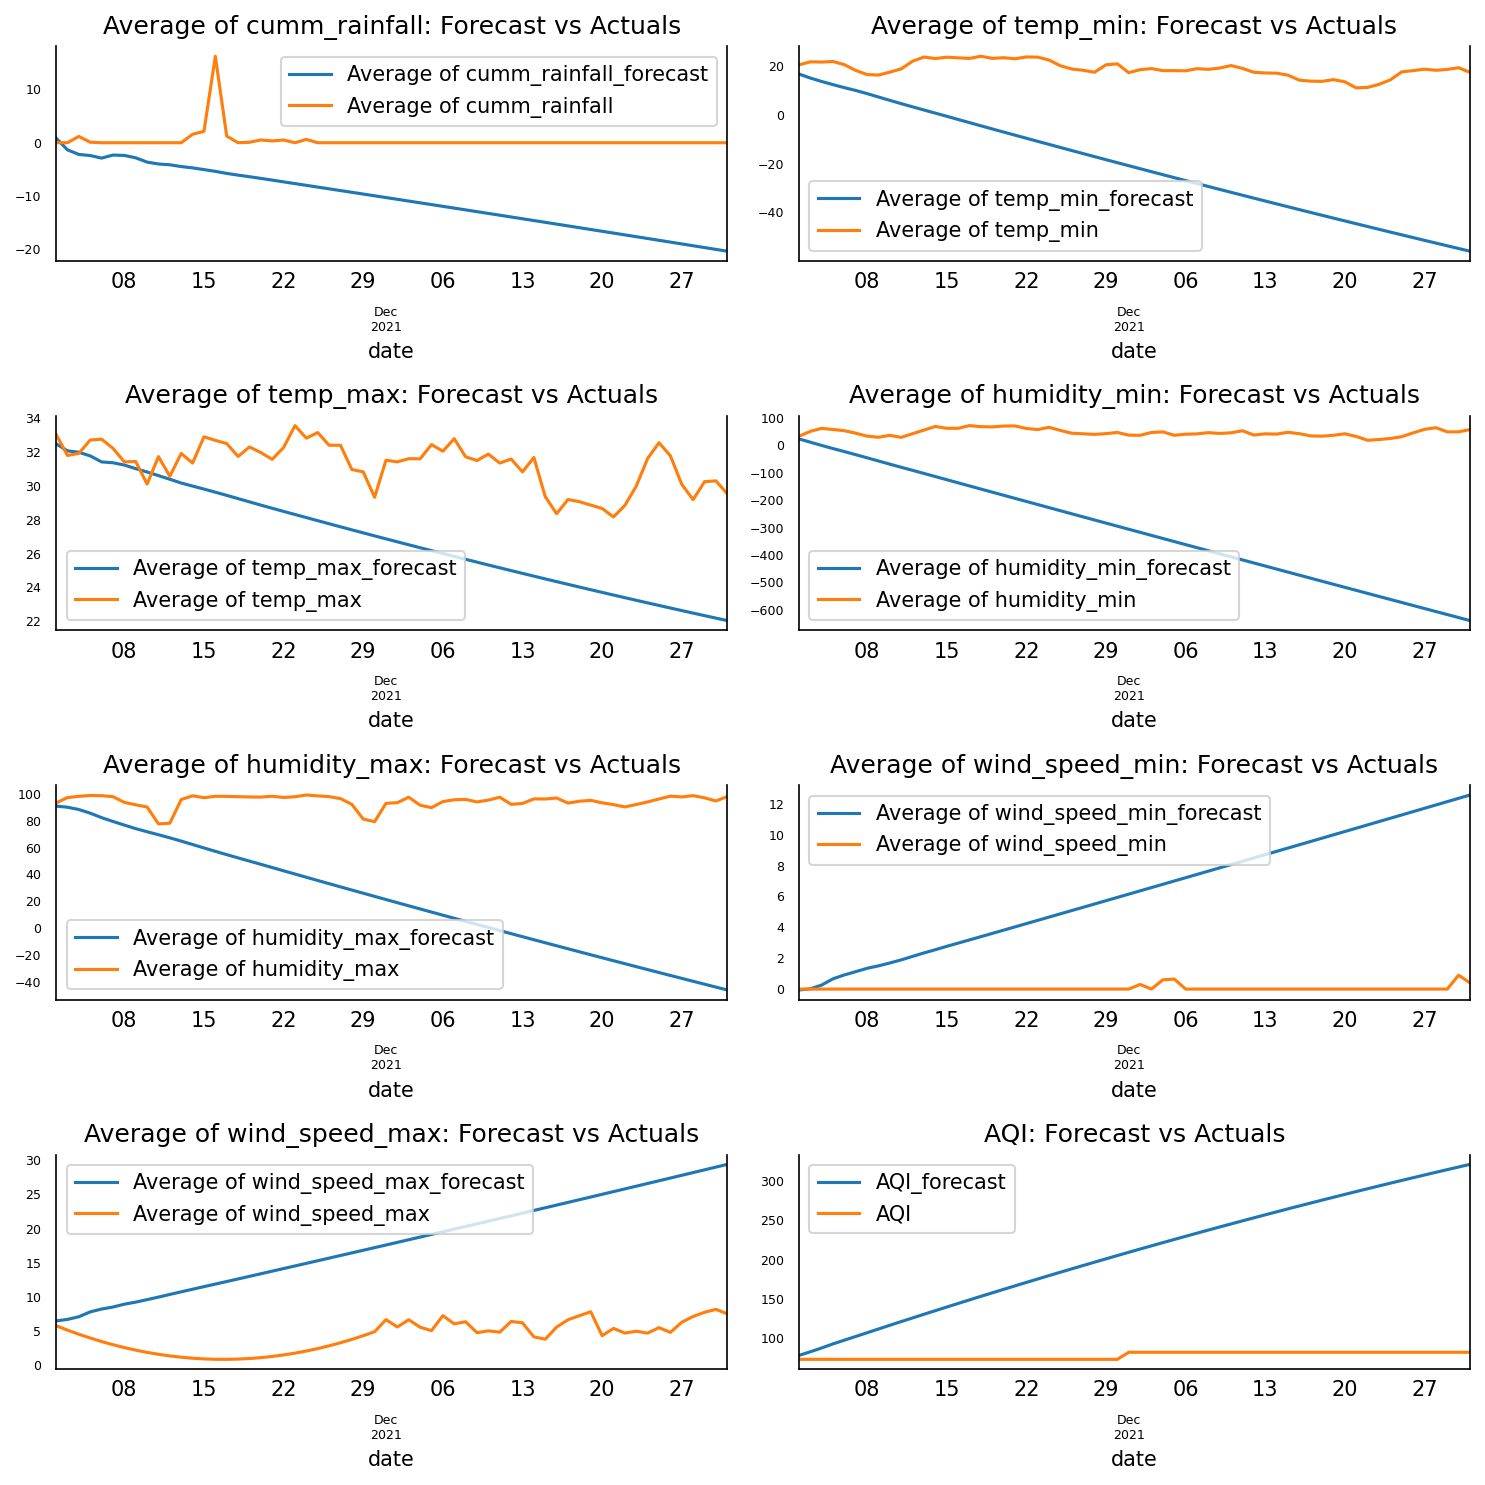

In [111]:
#Plot the forecasts
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();